### Regression
Six FDR values

In [2]:
import numpy as np

# Load the embeddings file again after code execution state reset
file_path = "/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/conversionOnly_biobert_embeddings.npy"
embeddings = np.load(file_path, allow_pickle=True).item()


In [3]:
# Check number of entries
print(f"Number of genes: {len(embeddings)}")

# View shape of one embedding
first_key = list(embeddings.keys())[0]
print(f"Example gene ID: {first_key}")
print(f"First 10 gene IDs:", list(embeddings)[0:10])
print(f"Embedding shape: {embeddings[first_key].shape}")

Number of genes: 452
Example gene ID: LINC01518
First 10 gene IDs: ['LINC01518', 'LINC00842', 'SGMS1-AS1', 'CCEPR', 'MRLN', 'UNC5B-AS1', 'LINC00339', 'KCNMA1-AS1', 'LINC01342', 'LINC00857']
Embedding shape: (768,)


In [4]:
# Re-import libraries after kernel reset
import numpy as np
import pandas as pd

# Reload embeddings and data files
embedding_data = np.load(file_path, allow_pickle=True).item()
final_df = pd.read_csv("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/final.tsv", sep="\t")
supp_df = pd.read_csv("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/Supplementary_table12.csv")

# Prepare mapping and relevant keys
embedding_keys = set(embedding_data.keys())
final_incoming_keys = set(final_df['incoming'].dropna().astype(str).unique())
supp_gene_ids = set(supp_df['Gene_ID'].dropna().astype(str).unique())

# Map from 'incoming' → 'Gene_ID'
incoming_to_geneid = dict(zip(final_df['incoming'].astype(str), final_df['Gene_ID'].astype(str)))

# FDR columns of interest
fdr_columns = [
    'LN18.dropFDR',
    'LN229.dropFDR',
    'A549.dropFDR',
    'NCIH460.dropFDR',
    'KP4.dropFDR',
    'MIAPACA2.dropFDR'
]

# Build X and Y datasets
X, Y, matched_genes = [], [], []

for incoming_gene, embedding in embedding_data.items():
    if incoming_gene not in incoming_to_geneid:
        continue
    
    gene_id = incoming_to_geneid[incoming_gene]
    fdr_row = supp_df[supp_df['Gene_ID'] == gene_id]
    
    if fdr_row.empty:
        continue
    
    fdr_values = fdr_row[fdr_columns].values.flatten()
    if np.any(pd.isna(fdr_values)):
        continue
    
    X.append(embedding)
    Y.append(fdr_values)
    matched_genes.append(incoming_gene)

X = np.stack(X)
Y = np.stack(Y)

X.shape, Y.shape, len(matched_genes)


((443, 768), (443, 6), 443)

## dataset for RRA and LFC values

In [5]:
import numpy as np
import pandas as pd

# Load BioBERT embeddings
embeddings = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/conversionOnly_biobert_embeddings.npy", allow_pickle=True).item()

# Load final.tsv file
final_df = pd.read_csv("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/final.tsv", sep="\t")

# Define the relevant columns to extract
target_columns = [
    'LN18.RRAscore', 'LN229.RRAscore', 'A549.RRAscore', 'NCIH460.RRAscore', 'KP4.RRAscore', 'MIAPACA2.RRAscore',
    'LN18.LFC', 'LN229.LFC', 'A549.LFC', 'NCIH460.LFC', 'KP4.LFC', 'MIAPACA2.LFC'
]

# Initialize lists
X = []
Y = []
gene_ids_used = []

# Iterate over genes in the embedding dictionary
for gene_name, embedding in embeddings.items():
    # Match to final_df using "Incoming" column
    match_row = final_df[final_df["incoming"] == gene_name]

    if not match_row.empty:
        # Check if all required columns are present and not null
        row_values = match_row.iloc[0][target_columns]
        if not row_values.isnull().any():
            X.append(embedding)
            Y.append(row_values.values.astype(float))
            gene_ids_used.append(gene_name)

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

print(f"Dataset created.")
print(f"Number of genes: {len(X)}")
print(f"Input shape (BioBERT embeddings): {X.shape}")
print(f"Output shape (target columns): {Y.shape}")


Dataset created.
Number of genes: 452
Input shape (BioBERT embeddings): (452, 768)
Output shape (target columns): (452, 12)


In [6]:
import numpy as np

# Assume Y is shape (452, 12): first 6 cols are RRA, last 6 are LFC
Y_rra = Y[:, :6]
Y_lfc = Y[:, 6:]

# Discretize RRA into quartiles → values: 0, 1, 2, 3
Y_rra_quartiles = np.floor(Y_rra * 4).astype(int)
Y_rra_quartiles[Y_rra_quartiles == 4] = 3  # cap at 3

# Convert LFC into binary: 1 if > 0 else 0
Y_lfc_binary = (Y_lfc > 0).astype(int)

# Final labels
# We'll flatten each target group per sample
# RRA: shape (452, 6) → (452, 6) [values 0-3]
# LFC: shape (452, 6) → (452, 6) [values 0/1]


RRA quartile classes (Y_rra_quartiles) → multi-class (4 classes)

LFC binary classes (Y_lfc_binary) → binary (2 classes)

RRA Quartile Class Distributions:
LN18: {3: 101, 0: 157, 2: 110, 1: 84}
LN229: {0: 172, 2: 82, 3: 112, 1: 86}
A549: {0: 151, 3: 98, 2: 94, 1: 109}
NCIH460: {0: 157, 1: 77, 3: 122, 2: 96}
KP4: {0: 159, 1: 71, 3: 123, 2: 99}
MIAPACA2: {0: 178, 3: 112, 2: 72, 1: 90}


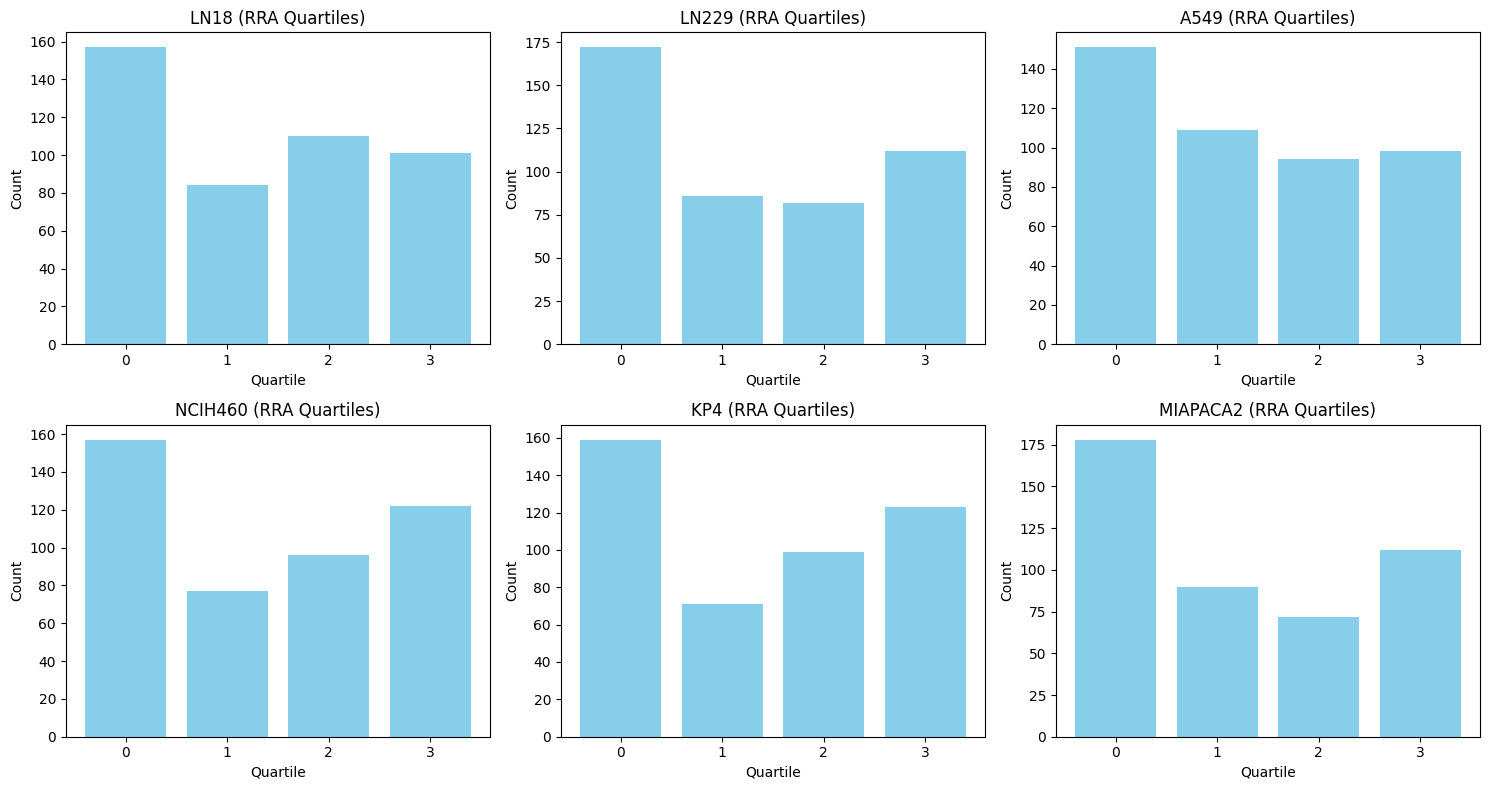


LFC Binary Class Distributions:
LN18: {0: 334, 1: 118}
LN229: {0: 315, 1: 137}
A549: {0: 302, 1: 150}
NCIH460: {0: 326, 1: 126}
KP4: {0: 322, 1: 130}
MIAPACA2: {0: 328, 1: 124}


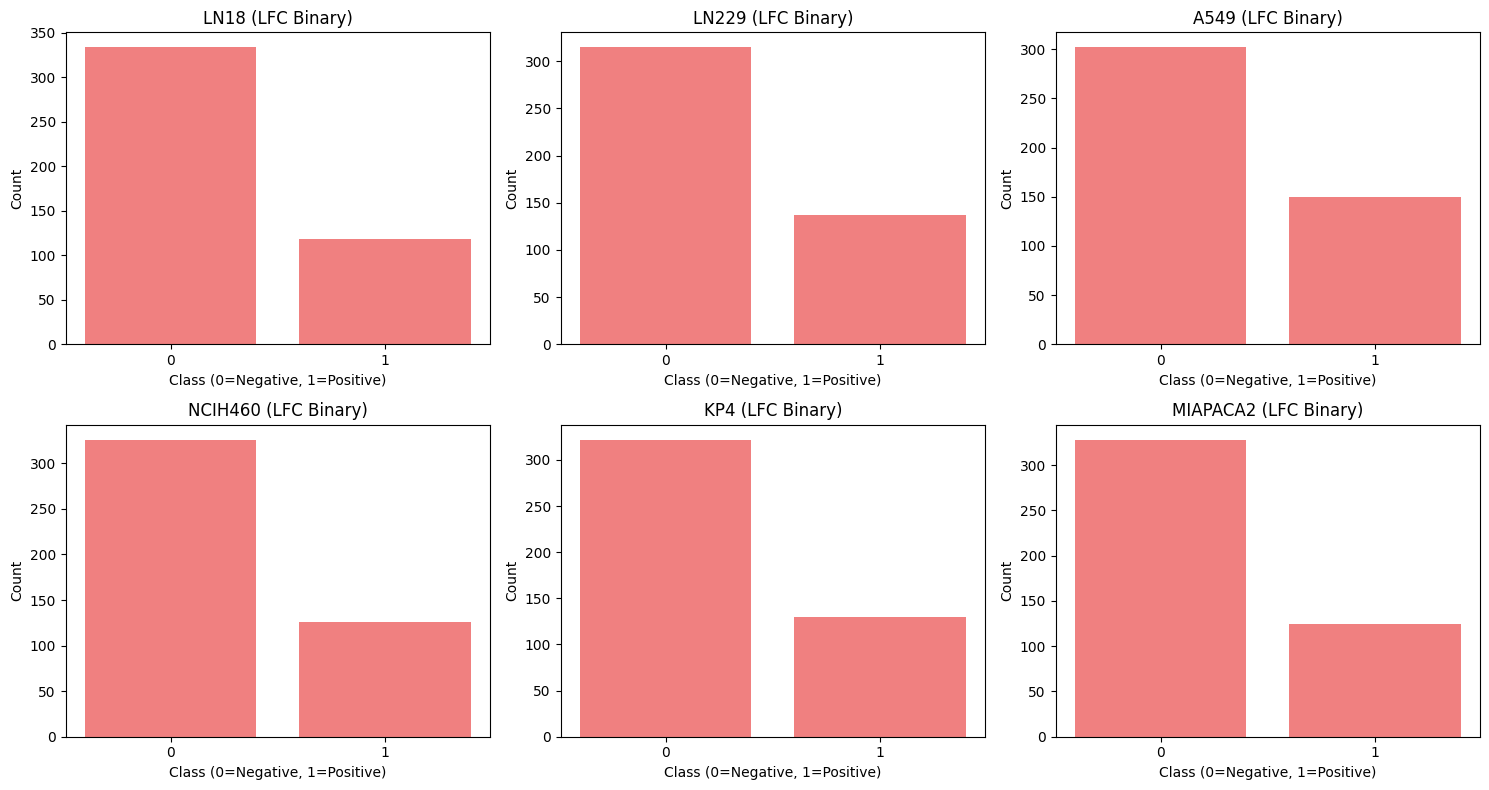

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_label_distributions(Y_rra_quartiles, Y_lfc_binary, task_names=None):
    num_tasks = Y_rra_quartiles.shape[1]
    if task_names is None:
        task_names = [f'Task {i+1}' for i in range(num_tasks)]

    # RRA Quartiles (4-class)
    print("RRA Quartile Class Distributions:")
    fig_rra, axes_rra = plt.subplots(2, 3, figsize=(15, 8))
    for i in range(num_tasks):
        dist = Counter(Y_rra_quartiles[:, i])
        print(f"{task_names[i]}: {dict(dist)}")
        ax = axes_rra[i // 3][i % 3]
        ax.bar(dist.keys(), dist.values(), color='skyblue')
        ax.set_title(f"{task_names[i]} (RRA Quartiles)")
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xlabel("Quartile")
        ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # LFC Binary
    print("\nLFC Binary Class Distributions:")
    fig_lfc, axes_lfc = plt.subplots(2, 3, figsize=(15, 8))
    for i in range(num_tasks):
        dist = Counter(Y_lfc_binary[:, i])
        print(f"{task_names[i]}: {dict(dist)}")
        ax = axes_lfc[i // 3][i % 3]
        ax.bar(dist.keys(), dist.values(), color='lightcoral')
        ax.set_title(f"{task_names[i]} (LFC Binary)")
        ax.set_xticks([0, 1])
        ax.set_xlabel("Class (0=Negative, 1=Positive)")
        ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

task_labels = ['LN18', 'LN229', 'A549', 'NCIH460', 'KP4', 'MIAPACA2']
plot_label_distributions(Y_rra_quartiles, Y_lfc_binary, task_labels)



multi-task classification setup with:

6 × RRA scores → 4-class classification (quartiles)

6 × LFC scores → binary classification (positive/negative)

So the MLP must:

Output logits for 6×4 = 24 classes (RRA)

Output logits for 6×1 = 6 binary labels (LFC)
Total output shape = 30

In [8]:
import torch
import torch.nn as nn

class MultiTaskMLP(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256):
        super(MultiTaskMLP, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        
        self.rra_head = nn.Linear(hidden_dim, 6 * 4)   # 6 RRA targets, each with 4 classes
        self.lfc_head = nn.Linear(hidden_dim, 6 * 2)   # 6 LFC targets, binary (we'll reshape)

    def forward(self, x):
        h = self.shared(x)
        rra_logits = self.rra_head(h).reshape(-1, 6, 4)  # shape: (batch, 6, 4)
        lfc_logits = self.lfc_head(h).reshape(-1, 6, 2)  # shape: (batch, 6, 2)
        return rra_logits, lfc_logits


In [9]:
# Compute per-task class weights
def compute_weights(y_true, num_classes):
    weights = []
    for i in range(y_true.shape[1]):
        class_sample_count = np.array([(y_true[:, i] == t).sum() for t in range(num_classes)])
        class_weights = 1. / (class_sample_count + 1e-6)
        weights.append(torch.tensor(class_weights, dtype=torch.float32))
    return weights

rra_weights = compute_weights(Y_rra_quartiles, 4)
lfc_weights = compute_weights(Y_lfc_binary, 2)

# Loss function with per-task weights
def multitask_loss(rra_logits, lfc_logits, rra_labels, lfc_labels):
    loss = 0
    for i in range(6):
        ce_rra = nn.CrossEntropyLoss(weight=rra_weights[i])
        ce_lfc = nn.CrossEntropyLoss(weight=lfc_weights[i])
        loss += ce_rra(rra_logits[:, i, :], rra_labels[:, i])
        loss += ce_lfc(lfc_logits[:, i, :], lfc_labels[:, i])
    return loss / 12

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

# Assume the following are already defined:
# X: (452, 768) embeddings
# Y_rra_quartiles: (452, 6) integer labels in [0-3]
# Y_lfc_binary: (452, 6) integer labels in [0, 1]

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_rra_tensor = torch.tensor(Y_rra_quartiles, dtype=torch.long)
Y_lfc_tensor = torch.tensor(Y_lfc_binary, dtype=torch.long)

# Dataset and splits
dataset = TensorDataset(X_tensor, Y_rra_tensor, Y_lfc_tensor)
train_len = int(0.7 * len(dataset))
val_len = int(0.15 * len(dataset))
test_len = len(dataset) - train_len - val_len
train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [11]:
model = MultiTaskMLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Training with early stopping
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
best_model_state = None

for epoch in range(500):
    model.train()
    total_train_loss = 0
    for xb, yb_rra, yb_lfc in train_loader:
        optimizer.zero_grad()
        rra_pred, lfc_pred = model(xb)
        loss = multitask_loss(rra_pred, lfc_pred, yb_rra, yb_lfc)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb_rra, yb_lfc in val_loader:
            rra_pred, lfc_pred = model(xb)
            val_loss = multitask_loss(rra_pred, lfc_pred, yb_rra, yb_lfc)
            total_val_loss += val_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss = 1.0448, Val Loss = 1.0413
Epoch 2: Train Loss = 1.0417, Val Loss = 1.0489
Epoch 3: Train Loss = 1.0412, Val Loss = 1.0402
Epoch 4: Train Loss = 1.0392, Val Loss = 1.0434
Epoch 5: Train Loss = 1.0371, Val Loss = 1.0390
Epoch 6: Train Loss = 1.0384, Val Loss = 1.0394
Epoch 7: Train Loss = 1.0369, Val Loss = 1.0451
Epoch 8: Train Loss = 1.0373, Val Loss = 1.0403
Epoch 9: Train Loss = 1.0347, Val Loss = 1.0411
Epoch 10: Train Loss = 1.0355, Val Loss = 1.0461
Epoch 11: Train Loss = 1.0335, Val Loss = 1.0446
Epoch 12: Train Loss = 1.0330, Val Loss = 1.0417
Epoch 13: Train Loss = 1.0310, Val Loss = 1.0415
Epoch 14: Train Loss = 1.0290, Val Loss = 1.0420
Epoch 15: Train Loss = 1.0277, Val Loss = 1.0454
Epoch 16: Train Loss = 1.0288, Val Loss = 1.0489
Epoch 17: Train Loss = 1.0224, Val Loss = 1.0565
Epoch 18: Train Loss = 1.0255, Val Loss = 1.0488
Epoch 19: Train Loss = 1.0205, Val Loss = 1.0522
Epoch 20: Train Loss = 1.0208, Val Loss = 1.0476
Epoch 21: Train Loss = 1.0142

In [12]:
# Load best model
model.load_state_dict(best_model_state)

# Evaluation on test set
model.eval()
all_rra_true = []
all_rra_pred = []
all_lfc_true = []
all_lfc_pred = []

with torch.no_grad():
    for xb, yb_rra, yb_lfc in test_loader:
        rra_logits, lfc_logits = model(xb)
        rra_preds = rra_logits.argmax(dim=2).numpy()
        lfc_preds = lfc_logits.argmax(dim=2).numpy()
        all_rra_true.append(yb_rra.numpy())
        all_rra_pred.append(rra_preds)
        all_lfc_true.append(yb_lfc.numpy())
        all_lfc_pred.append(lfc_preds)

rra_true = np.vstack(all_rra_true)
rra_pred = np.vstack(all_rra_pred)
lfc_true = np.vstack(all_lfc_true)
lfc_pred = np.vstack(all_lfc_pred)

# Per-class F1 and AUC
for i in range(6):
    f1 = f1_score(lfc_true[:, i], lfc_pred[:, i], zero_division=0)
    try:
        auc = roc_auc_score(lfc_true[:, i], lfc_pred[:, i])
    except ValueError:
        auc = float('nan')
    print(f"LFC Task {i+1}: F1 = {f1:.3f}, ROC-AUC = {auc:.3f}")

for i in range(6):
    f1_macro = f1_score(rra_true[:, i], rra_pred[:, i], average='macro', zero_division=0)
    print(f"RRA Task {i+1}: Macro F1 = {f1_macro:.3f}")

LFC Task 1: F1 = 0.414, ROC-AUC = 0.618
LFC Task 2: F1 = 0.364, ROC-AUC = 0.572
LFC Task 3: F1 = 0.441, ROC-AUC = 0.549
LFC Task 4: F1 = 0.267, ROC-AUC = 0.456
LFC Task 5: F1 = 0.387, ROC-AUC = 0.475
LFC Task 6: F1 = 0.339, ROC-AUC = 0.474
RRA Task 1: Macro F1 = 0.232
RRA Task 2: Macro F1 = 0.213
RRA Task 3: Macro F1 = 0.110
RRA Task 4: Macro F1 = 0.258
RRA Task 5: Macro F1 = 0.271
RRA Task 6: Macro F1 = 0.203


In [13]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

# Load best model
model.load_state_dict(best_model_state)
model.eval()

all_rra_true = []
all_rra_pred = []
all_lfc_true = []
all_lfc_pred = []

with torch.no_grad():
    for xb, yb_rra, yb_lfc in test_loader:
        rra_logits, lfc_logits = model(xb)
        rra_preds = rra_logits.argmax(dim=2).numpy()
        lfc_preds = lfc_logits.argmax(dim=2).numpy()
        all_rra_true.append(yb_rra.numpy())
        all_rra_pred.append(rra_preds)
        all_lfc_true.append(yb_lfc.numpy())
        all_lfc_pred.append(lfc_preds)

rra_true = np.vstack(all_rra_true)
rra_pred = np.vstack(all_rra_pred)
lfc_true = np.vstack(all_lfc_true)
lfc_pred = np.vstack(all_lfc_pred)

print("=== LFC Task Evaluation (Binary Classification) ===")
for i in range(6):
    f1 = f1_score(lfc_true[:, i], lfc_pred[:, i], zero_division=0)
    precision = precision_score(lfc_true[:, i], lfc_pred[:, i], zero_division=0)
    recall = recall_score(lfc_true[:, i], lfc_pred[:, i], zero_division=0)
    try:
        auc = roc_auc_score(lfc_true[:, i], lfc_pred[:, i])
    except ValueError:
        auc = float('nan')
    print(f"LFC Task {i+1}: F1 = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}, ROC-AUC = {auc:.3f}")

print("\n=== RRA Task Evaluation (Multi-class Classification) ===")
for i in range(6):
    f1_macro = f1_score(rra_true[:, i], rra_pred[:, i], average='macro', zero_division=0)
    precision_macro = precision_score(rra_true[:, i], rra_pred[:, i], average='macro', zero_division=0)
    recall_macro = recall_score(rra_true[:, i], rra_pred[:, i], average='macro', zero_division=0)
    print(f"RRA Task {i+1}: Macro F1 = {f1_macro:.3f}, Precision = {precision_macro:.3f}, Recall = {recall_macro:.3f}")


=== LFC Task Evaluation (Binary Classification) ===
LFC Task 1: F1 = 0.414, Precision = 0.600, Recall = 0.316, ROC-AUC = 0.618
LFC Task 2: F1 = 0.364, Precision = 0.276, Recall = 0.533, ROC-AUC = 0.572
LFC Task 3: F1 = 0.441, Precision = 0.342, Recall = 0.619, ROC-AUC = 0.549
LFC Task 4: F1 = 0.267, Precision = 0.240, Recall = 0.300, ROC-AUC = 0.456
LFC Task 5: F1 = 0.387, Precision = 0.300, Recall = 0.545, ROC-AUC = 0.475
LFC Task 6: F1 = 0.339, Precision = 0.244, Recall = 0.556, ROC-AUC = 0.474

=== RRA Task Evaluation (Multi-class Classification) ===
RRA Task 1: Macro F1 = 0.232, Precision = 0.291, Recall = 0.285
RRA Task 2: Macro F1 = 0.213, Precision = 0.191, Recall = 0.241
RRA Task 3: Macro F1 = 0.110, Precision = 0.164, Recall = 0.231
RRA Task 4: Macro F1 = 0.258, Precision = 0.313, Recall = 0.289
RRA Task 5: Macro F1 = 0.271, Precision = 0.251, Recall = 0.298
RRA Task 6: Macro F1 = 0.203, Precision = 0.275, Recall = 0.295


## Separate MLP models for LFC and RRA

Data split for RRA and LFC encoding

In [14]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# Load the full data from the previous step
X = X # np.load("/mnt/data/X_final.npy")            # shape: (452, 768)
Y = Y # np.load("/mnt/data/Y_final.npy")            # shape: (452, 12)

# Split Y into RRA and LFC parts
Y_rra = Y[:, :6]  # First 6 columns: RRA scores (float)
Y_lfc = Y[:, 6:]  # Last 6 columns: LFC values (float)

# Binarize LFC: 1 if LFC > 0, else 0
Y_lfc_binary = (Y_lfc > 0).astype(int)

# For RRA: Bin into quartiles (0: Q1, 1: Q2, 2: Q3, 3: Q4)
Y_rra_quartile = np.zeros_like(Y_rra, dtype=int)
for i in range(Y_rra.shape[1]):
    col = Y_rra[:, i]
    thresholds = np.quantile(col, [0.25, 0.5, 0.75])
    Y_rra_quartile[:, i] = np.digitize(col, bins=thresholds)

# Split into train/val/test
X_train, X_temp, y_lfc_train, y_lfc_temp = train_test_split(
    X, Y_lfc_binary, test_size=0.3, random_state=42, stratify=Y_lfc_binary[:, 0]  # stratify on 1st task
)
X_val, X_test, y_lfc_val, y_lfc_test = train_test_split(
    X_temp, y_lfc_temp, test_size=0.5, random_state=42, stratify=y_lfc_temp[:, 0]
)

# Output the shapes
X_train.shape, X_val.shape, X_test.shape, y_lfc_train.shape


((316, 768), (68, 768), (68, 768), (316, 6))

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_lfc_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_lfc_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_lfc_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

# Compute class imbalance for pos_weight
pos_weights = (1.0 - y_lfc_train.mean(axis=0)) / y_lfc_train.mean(axis=0)
pos_weights = torch.tensor(pos_weights, dtype=torch.float32).to(device)

# Define MLP model
class LFCClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 6)  # 6 binary tasks
        )
    
    def forward(self, x):
        return self.model(x)

model = LFCClassifier().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with early stopping
best_model_state = None
best_val_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in range(500):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ----------------------
#  Evaluation
# ----------------------

# Load best model
model.load_state_dict(best_model_state)
model.eval()

all_true, all_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_pred.append(preds)
        all_true.append(yb.numpy())

y_true = np.vstack(all_true)
y_pred = np.vstack(all_pred)

# Metrics
for i in range(6):
    f1 = f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
    prec = precision_score(y_true[:, i], y_pred[:, i], zero_division=0)
    rec = recall_score(y_true[:, i], y_pred[:, i], zero_division=0)
    try:
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
    except ValueError:
        auc = float('nan')
    print(f"LFC Task {i+1}: F1 = {f1:.3f}, Precision = {prec:.3f}, Recall = {rec:.3f}, ROC-AUC = {auc:.3f}")


Epoch 1: Train Loss = 0.9892, Val Loss = 1.0163
Epoch 2: Train Loss = 0.9854, Val Loss = 1.0165
Epoch 3: Train Loss = 0.9820, Val Loss = 1.0161
Epoch 4: Train Loss = 0.9835, Val Loss = 1.0185
Epoch 5: Train Loss = 0.9847, Val Loss = 1.0125
Epoch 6: Train Loss = 0.9819, Val Loss = 1.0207
Epoch 7: Train Loss = 0.9824, Val Loss = 1.0161
Epoch 8: Train Loss = 0.9806, Val Loss = 1.0038
Epoch 9: Train Loss = 0.9862, Val Loss = 1.0184
Epoch 10: Train Loss = 0.9874, Val Loss = 1.0150
Epoch 11: Train Loss = 0.9829, Val Loss = 1.0152
Epoch 12: Train Loss = 0.9823, Val Loss = 1.0121
Epoch 13: Train Loss = 0.9788, Val Loss = 1.0105
Epoch 14: Train Loss = 0.9806, Val Loss = 1.0137
Epoch 15: Train Loss = 0.9805, Val Loss = 1.0061
Epoch 16: Train Loss = 0.9782, Val Loss = 1.0081
Epoch 17: Train Loss = 0.9780, Val Loss = 1.0113
Epoch 18: Train Loss = 0.9778, Val Loss = 1.0083
Epoch 19: Train Loss = 0.9783, Val Loss = 1.0127
Epoch 20: Train Loss = 0.9748, Val Loss = 1.0125
Epoch 21: Train Loss = 0.9818

## Separate models for six sub-types of LFC

In [16]:
embeddings = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/all_biobert_embeddings_50_dim.npy", allow_pickle=True)
type(embedding)

numpy.ndarray

In [17]:
embeddings = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/lncrna_to_embedding.pkl", allow_pickle=True)

In [130]:
len(embeddings)

1333

In [18]:
for lncrnatype, emb in embeddings.items():
    if isinstance(emb, np.ndarray):
        print(f"lncRNA_name: {lncrnatype}, Embedding shape: {emb.shape}")
    else:
        print(f"lncRNA_name: {lncrnatype}, Embedding len: {len(emb)}")

lncRNA_name: LINC00313, Embedding len: 128
lncRNA_name: FAM83H-AS1, Embedding len: 128
lncRNA_name: NEAT1, Embedding len: 128
lncRNA_name: ZFPM2-AS1, Embedding len: 128
lncRNA_name: SNHG1, Embedding len: 128
lncRNA_name: LINC00222, Embedding len: 128
lncRNA_name: TP73-AS1, Embedding len: 128
lncRNA_name: PVT1, Embedding len: 128
lncRNA_name: FEZF1-AS1, Embedding len: 128
lncRNA_name: DANCR, Embedding len: 128
lncRNA_name: HOTTIP, Embedding len: 128
lncRNA_name: CCAT1, Embedding len: 128
lncRNA_name: GAS5, Embedding len: 128
lncRNA_name: CCDC26, Embedding len: 128
lncRNA_name: CRNDE, Embedding len: 128
lncRNA_name: LINC00858, Embedding len: 128
lncRNA_name: HOTAIR, Embedding len: 128
lncRNA_name: HAGLR, Embedding len: 128
lncRNA_name: TDRG1, Embedding len: 128
lncRNA_name: LIFR-AS1, Embedding len: 128
lncRNA_name: THORLNC, Embedding len: 128
lncRNA_name: LINC00339, Embedding len: 128
lncRNA_name: NNT-AS1, Embedding len: 128
lncRNA_name: CBR3-AS1, Embedding len: 128
lncRNA_name: ZEB2-AS1

In [19]:
import torch

# Load the file
file_path = "/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/lncRNA_embedding.pt"
data = torch.load(file_path)

# Inspect type
print(f"Type of loaded object: {type(data)}")

# If it's a dictionary
if isinstance(data, dict):
    print(f"Number of items: {len(data)}")
    keys = list(data.keys())[:5]
    print(f"First 5 keys: {keys}")
    print(f"Shape of first embedding: {data[keys[0]].shape if hasattr(data[keys[0]], 'shape') else type(data[keys[0]])}")

# If it's a tensor
elif isinstance(data, torch.Tensor):
    print(f"Tensor shape: {data.shape}")
    print(f"Tensor dtype: {data.dtype}")

# Other types
else:
    print(f"Unhandled type: {type(data)}")


Type of loaded object: <class 'torch.Tensor'>
Tensor shape: torch.Size([1333, 128])
Tensor dtype: torch.float32


In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Load BioBERT embeddings dictionary
embeddings = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/all_biobert_embeddings_128_dim (1).npy", allow_pickle=True).item()
embeddings = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/all_biobert_embeddings_50_dim.npy", allow_pickle=True).item()
#embeddings = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/node_embeddings_50d.pkl", allow_pickle=True)
embeddings = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/lncrna_to_embedding.pkl", allow_pickle=True)
# Load target table
final_df = pd.read_csv("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/final.tsv", sep="\t")

# Define target columns
lfc_columns = [
    'LN18.LFC', 'LN229.LFC', 'A549.LFC',
    'NCIH460.LFC', 'KP4.LFC', 'MIAPACA2.LFC'
]

# Build X and Y for LFC tasks
X = []
Ys = {col: [] for col in lfc_columns}
gene_ids = []

for gene, emb in embeddings.items():
    row = final_df[final_df["incoming"] == gene]
    if not row.empty:
        row = row.iloc[0]
        if not row[lfc_columns].isnull().any():
            X.append(emb)
            for col in lfc_columns:
                Ys[col].append(1 if row[col] > 0 else 0)  # Binary classification
            gene_ids.append(gene)

X = np.array(X).astype(np.float32)
Ys = {col: np.array(labels).astype(np.int64) for col, labels in Ys.items()}

print(f"Input shape: {X.shape}")
for col in lfc_columns:
    print(f"{col} label distribution: {np.bincount(Ys[col])}")


Input shape: (451, 128)
LN18.LFC label distribution: [334 117]
LN229.LFC label distribution: [315 136]
A549.LFC label distribution: [302 149]
NCIH460.LFC label distribution: [325 126]
KP4.LFC label distribution: [321 130]
MIAPACA2.LFC label distribution: [327 124]


In [21]:
# Load Node embeddings dictionary
embeddings_dict = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/node_embeddings_50d.pkl", allow_pickle=True)
lncrna_embeddings = embeddings_dict.get('lncRNA')  # shape: (1333, 50)
lncrna_embeddings = embeddings_dict.get("lncRNA")
if lncrna_embeddings is None:
    raise ValueError("lncRNA embeddings not found in the file")

In [22]:
for k,v in embeddings_dict.items():
    print(k)

miRNA
PCG
TF
lncRNA
snoRNA
circRNA


In [23]:
lncrna_embeddings.shape

(1333, 50)

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Load Node embeddings dictionary
embeddings_dict = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/node_embeddings_50d.pkl", allow_pickle=True)
lncrna_embeddings = embeddings_dict.get('lncRNA')  # shape: (1333, 50)

# Load target table
final_df = pd.read_csv("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/final.tsv", sep="\t")

# Define target columns
lfc_columns = [
    'LN18.LFC', 'LN229.LFC', 'A549.LFC',
    'NCIH460.LFC', 'KP4.LFC', 'MIAPACA2.LFC'
]

# Build X and Y for LFC tasks
X = []
Ys = {col: [] for col in lfc_columns}
gene_ids = []

for i, row in final_df.iterrows():
    gene = row['incoming']
    if gene in embeddings_dict['lncRNA']:
        emb_index = list(embeddings_dict['lncRNA']).index(gene)
        embedding = lncrna_embeddings[emb_index]
        if not row[lfc_columns].isnull().any():
            X.append(embedding)
            for col in lfc_columns:
                Ys[col].append(1 if row[col] > 0 else 0)
            gene_ids.append(gene)

X = np.array(X).astype(np.float32)
Ys = {col: np.array(labels).astype(np.int64) for col, labels in Ys.items()}

print(f"Input shape: {X.shape}")
for col in lfc_columns:
    print(f"{col} label distribution: {np.bincount(Ys[col])}")


Input shape: (0,)
LN18.LFC label distribution: []
LN229.LFC label distribution: []
A549.LFC label distribution: []
NCIH460.LFC label distribution: []
KP4.LFC label distribution: []
MIAPACA2.LFC label distribution: []


In [25]:
class LFCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [26]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)  # Output logits for binary classification
        )

    def forward(self, x):
        return self.model(x)


In [71]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)


In [30]:
from torch.nn.functional import cross_entropy
from copy import deepcopy

def train_single_lfc_task(X, y, task_name, epochs=100, patience=15, batch_size=2, lr=1e-3):
    dataset = LFCDataset(X, y)
    train_len = int(0.8 * len(dataset))
    val_len = len(dataset) - train_len
    train_set, val_set = random_split(dataset, [train_len, val_len])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    model = MLPBinaryClassifier(input_dim=X.shape[1])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Compute pos_weight to handle imbalance
    y_train = torch.tensor([y for _, y in train_set])
    pos_weight_val = (len(y_train) - y_train.sum()) / y_train.sum()
    pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight.item()]).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"[{task_name}] Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"[{task_name}] Early stopping triggered.")
                break

    # Load best model
    model.load_state_dict(best_model)

    # Evaluation
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for xb, yb in DataLoader(dataset, batch_size=batch_size):
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_true.extend(yb.numpy())
            all_pred.extend(preds)

    y_true = np.array(all_true)
    y_pred = np.array(all_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except:
        auc = float("nan")

    print(f"[{task_name}] F1 = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}, ROC-AUC = {auc:.3f}")


In [31]:
for i, task in enumerate(lfc_columns):
    print(f"\nTraining for task: {task}")
    train_single_lfc_task(X, Ys[task], task_name=task)



Training for task: LN18.LFC
[LN18.LFC] Epoch 1: Train Loss = 0.6868, Val Loss = 0.6633


/var/folders/jq/4s6sf2812b90mbpcbf2wyg1w0000gn/T/ipykernel_53787/2719341610.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32).to(device)


[LN18.LFC] Epoch 2: Train Loss = 0.6550, Val Loss = 0.6460
[LN18.LFC] Epoch 3: Train Loss = 0.6517, Val Loss = 0.6398
[LN18.LFC] Epoch 4: Train Loss = 0.6333, Val Loss = 0.6887
[LN18.LFC] Epoch 5: Train Loss = 0.6079, Val Loss = 0.6840
[LN18.LFC] Epoch 6: Train Loss = 0.5985, Val Loss = 0.6826
[LN18.LFC] Epoch 7: Train Loss = 0.6213, Val Loss = 0.7365
[LN18.LFC] Epoch 8: Train Loss = 0.5840, Val Loss = 0.7591
[LN18.LFC] Epoch 9: Train Loss = 0.5788, Val Loss = 0.7550
[LN18.LFC] Epoch 10: Train Loss = 0.5720, Val Loss = 0.7674
[LN18.LFC] Epoch 11: Train Loss = 0.5791, Val Loss = 0.7720
[LN18.LFC] Epoch 12: Train Loss = 0.5500, Val Loss = 0.8575
[LN18.LFC] Epoch 13: Train Loss = 0.5462, Val Loss = 0.8083
[LN18.LFC] Epoch 14: Train Loss = 0.5419, Val Loss = 0.8099
[LN18.LFC] Epoch 15: Train Loss = 0.5350, Val Loss = 0.8851
[LN18.LFC] Epoch 16: Train Loss = 0.5328, Val Loss = 0.8836
[LN18.LFC] Epoch 17: Train Loss = 0.5165, Val Loss = 0.9081
[LN18.LFC] Epoch 18: Train Loss = 0.5239, Val Lo

/var/folders/jq/4s6sf2812b90mbpcbf2wyg1w0000gn/T/ipykernel_53787/2719341610.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32).to(device)


[LN229.LFC] Epoch 3: Train Loss = 0.6487, Val Loss = 0.7243
[LN229.LFC] Epoch 4: Train Loss = 0.6503, Val Loss = 0.7105
[LN229.LFC] Epoch 5: Train Loss = 0.6320, Val Loss = 0.7169
[LN229.LFC] Epoch 6: Train Loss = 0.6257, Val Loss = 0.7133
[LN229.LFC] Epoch 7: Train Loss = 0.6243, Val Loss = 0.7361
[LN229.LFC] Epoch 8: Train Loss = 0.6258, Val Loss = 0.7746
[LN229.LFC] Epoch 9: Train Loss = 0.6067, Val Loss = 0.7338
[LN229.LFC] Epoch 10: Train Loss = 0.6113, Val Loss = 0.7193
[LN229.LFC] Epoch 11: Train Loss = 0.6012, Val Loss = 0.7731
[LN229.LFC] Epoch 12: Train Loss = 0.6019, Val Loss = 0.7513
[LN229.LFC] Epoch 13: Train Loss = 0.6016, Val Loss = 0.7456
[LN229.LFC] Epoch 14: Train Loss = 0.5962, Val Loss = 0.7621
[LN229.LFC] Epoch 15: Train Loss = 0.5778, Val Loss = 0.7466
[LN229.LFC] Epoch 16: Train Loss = 0.5825, Val Loss = 0.7689
[LN229.LFC] Early stopping triggered.
[LN229.LFC] F1 = 0.056, Precision = 0.500, Recall = 0.029, ROC-AUC = 0.508

Training for task: A549.LFC
[A549.LFC] 

/var/folders/jq/4s6sf2812b90mbpcbf2wyg1w0000gn/T/ipykernel_53787/2719341610.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32).to(device)


[A549.LFC] Epoch 2: Train Loss = 0.6778, Val Loss = 0.6252
[A549.LFC] Epoch 3: Train Loss = 0.6614, Val Loss = 0.6769
[A549.LFC] Epoch 4: Train Loss = 0.6601, Val Loss = 0.6511
[A549.LFC] Epoch 5: Train Loss = 0.6412, Val Loss = 0.6583
[A549.LFC] Epoch 6: Train Loss = 0.6473, Val Loss = 0.6463
[A549.LFC] Epoch 7: Train Loss = 0.6387, Val Loss = 0.6465
[A549.LFC] Epoch 8: Train Loss = 0.6264, Val Loss = 0.6666
[A549.LFC] Epoch 9: Train Loss = 0.6073, Val Loss = 0.6521
[A549.LFC] Epoch 10: Train Loss = 0.6096, Val Loss = 0.6898
[A549.LFC] Epoch 11: Train Loss = 0.6069, Val Loss = 0.7037
[A549.LFC] Epoch 12: Train Loss = 0.6051, Val Loss = 0.6556
[A549.LFC] Epoch 13: Train Loss = 0.5812, Val Loss = 0.6805
[A549.LFC] Epoch 14: Train Loss = 0.5820, Val Loss = 0.6923
[A549.LFC] Epoch 15: Train Loss = 0.5707, Val Loss = 0.6769
[A549.LFC] Epoch 16: Train Loss = 0.5570, Val Loss = 0.6463
[A549.LFC] Epoch 17: Train Loss = 0.5401, Val Loss = 0.6464
[A549.LFC] Early stopping triggered.
[A549.LFC] 

/var/folders/jq/4s6sf2812b90mbpcbf2wyg1w0000gn/T/ipykernel_53787/2719341610.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32).to(device)


[NCIH460.LFC] Epoch 2: Train Loss = 0.6475, Val Loss = 0.7040
[NCIH460.LFC] Epoch 3: Train Loss = 0.6339, Val Loss = 0.7224
[NCIH460.LFC] Epoch 4: Train Loss = 0.6285, Val Loss = 0.7027
[NCIH460.LFC] Epoch 5: Train Loss = 0.6076, Val Loss = 0.8050
[NCIH460.LFC] Epoch 6: Train Loss = 0.5930, Val Loss = 0.7326
[NCIH460.LFC] Epoch 7: Train Loss = 0.5978, Val Loss = 0.7406
[NCIH460.LFC] Epoch 8: Train Loss = 0.5952, Val Loss = 0.7340
[NCIH460.LFC] Epoch 9: Train Loss = 0.5717, Val Loss = 0.8974
[NCIH460.LFC] Epoch 10: Train Loss = 0.5804, Val Loss = 0.7604
[NCIH460.LFC] Epoch 11: Train Loss = 0.5526, Val Loss = 0.7611
[NCIH460.LFC] Epoch 12: Train Loss = 0.5451, Val Loss = 0.7841
[NCIH460.LFC] Epoch 13: Train Loss = 0.5493, Val Loss = 0.8185
[NCIH460.LFC] Epoch 14: Train Loss = 0.5436, Val Loss = 0.8384
[NCIH460.LFC] Epoch 15: Train Loss = 0.5325, Val Loss = 0.8456
[NCIH460.LFC] Epoch 16: Train Loss = 0.5134, Val Loss = 0.7907
[NCIH460.LFC] Epoch 17: Train Loss = 0.5154, Val Loss = 0.8448


/var/folders/jq/4s6sf2812b90mbpcbf2wyg1w0000gn/T/ipykernel_53787/2719341610.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32).to(device)


[KP4.LFC] Epoch 1: Train Loss = 0.6895, Val Loss = 0.7252
[KP4.LFC] Epoch 2: Train Loss = 0.6444, Val Loss = 0.7098
[KP4.LFC] Epoch 3: Train Loss = 0.6383, Val Loss = 0.7304
[KP4.LFC] Epoch 4: Train Loss = 0.6346, Val Loss = 0.7094
[KP4.LFC] Epoch 5: Train Loss = 0.6312, Val Loss = 0.7345
[KP4.LFC] Epoch 6: Train Loss = 0.6235, Val Loss = 0.7519
[KP4.LFC] Epoch 7: Train Loss = 0.5953, Val Loss = 0.7500
[KP4.LFC] Epoch 8: Train Loss = 0.5968, Val Loss = 0.7720
[KP4.LFC] Epoch 9: Train Loss = 0.6026, Val Loss = 0.7525
[KP4.LFC] Epoch 10: Train Loss = 0.5854, Val Loss = 0.8152
[KP4.LFC] Epoch 11: Train Loss = 0.5825, Val Loss = 0.8350
[KP4.LFC] Epoch 12: Train Loss = 0.5875, Val Loss = 0.8159
[KP4.LFC] Epoch 13: Train Loss = 0.5918, Val Loss = 0.8166
[KP4.LFC] Epoch 14: Train Loss = 0.5601, Val Loss = 0.8444
[KP4.LFC] Epoch 15: Train Loss = 0.5530, Val Loss = 0.8501
[KP4.LFC] Epoch 16: Train Loss = 0.5459, Val Loss = 0.8603
[KP4.LFC] Epoch 17: Train Loss = 0.5457, Val Loss = 0.8251
[KP4.L

/var/folders/jq/4s6sf2812b90mbpcbf2wyg1w0000gn/T/ipykernel_53787/2719341610.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32).to(device)


[MIAPACA2.LFC] Epoch 3: Train Loss = 0.6269, Val Loss = 0.7837
[MIAPACA2.LFC] Epoch 4: Train Loss = 0.6054, Val Loss = 0.7419
[MIAPACA2.LFC] Epoch 5: Train Loss = 0.5996, Val Loss = 0.7580
[MIAPACA2.LFC] Epoch 6: Train Loss = 0.5731, Val Loss = 0.7998
[MIAPACA2.LFC] Epoch 7: Train Loss = 0.5789, Val Loss = 0.8222
[MIAPACA2.LFC] Epoch 8: Train Loss = 0.5735, Val Loss = 0.9340
[MIAPACA2.LFC] Epoch 9: Train Loss = 0.5711, Val Loss = 0.8258
[MIAPACA2.LFC] Epoch 10: Train Loss = 0.5534, Val Loss = 0.9810
[MIAPACA2.LFC] Epoch 11: Train Loss = 0.5721, Val Loss = 0.8962
[MIAPACA2.LFC] Epoch 12: Train Loss = 0.5482, Val Loss = 0.9637
[MIAPACA2.LFC] Epoch 13: Train Loss = 0.5644, Val Loss = 0.8146
[MIAPACA2.LFC] Epoch 14: Train Loss = 0.5392, Val Loss = 0.8281
[MIAPACA2.LFC] Epoch 15: Train Loss = 0.5335, Val Loss = 0.8884
[MIAPACA2.LFC] Epoch 16: Train Loss = 0.5205, Val Loss = 0.9054
[MIAPACA2.LFC] Epoch 17: Train Loss = 0.5247, Val Loss = 0.8975
[MIAPACA2.LFC] Early stopping triggered.
[MIAPA

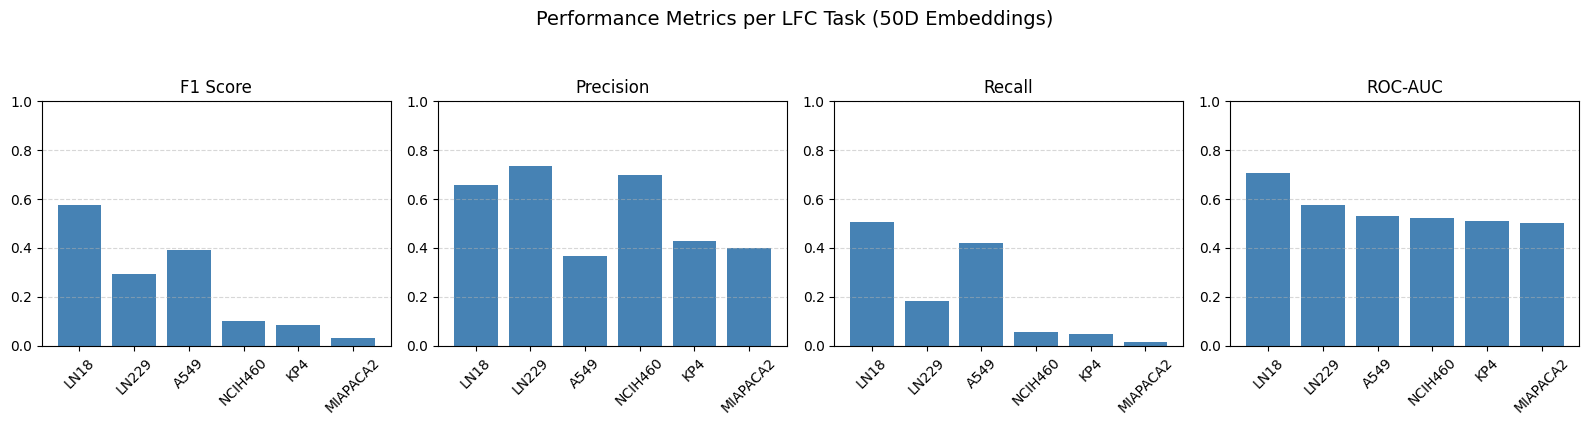

In [32]:
import matplotlib.pyplot as plt

# Metrics for each task
tasks = ['LN18', 'LN229', 'A549', 'NCIH460', 'KP4', 'MIAPACA2']
f1 =        [0.574, 0.292, 0.393, 0.103, 0.083, 0.031]
precision = [0.659, 0.735, 0.368, 0.700, 0.429, 0.400]
recall =    [0.508, 0.182, 0.420, 0.056, 0.046, 0.016]
roc_auc =   [0.708, 0.577, 0.531, 0.523, 0.511, 0.503]

metrics = {
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'ROC-AUC': roc_auc
}

# Plot
plt.figure(figsize=(16, 4))
for i, (name, values) in enumerate(metrics.items(), 1):
    plt.subplot(1, 4, i)
    plt.bar(tasks, values, color='steelblue')
    plt.ylim(0, 1)
    plt.title(name)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Performance Metrics per LFC Task (50D Embeddings)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


## Separate classifers for six sub-types of RRA

In [33]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Load Node embeddings dictionary
embeddings_dict = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/lncrna_to_embedding.pkl", allow_pickle=True)

# Load target table
final_df = pd.read_csv("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/final.tsv", sep="\t")

# Define RRA target columns
rra_columns = [
    'LN18.RRAscore', 'LN229.RRAscore', 'A549.RRAscore',
    'NCIH460.RRAscore', 'KP4.RRAscore', 'MIAPACA2.RRAscore'
]

# Build X and Y using 'incoming' column for gene-to-embedding matching
X = []
Ys = {col: [] for col in rra_columns}
gene_ids = []

for gene, emb in embeddings_dict.items():
    row = final_df[final_df["incoming"] == gene]
    if not row.empty:
        row = row.iloc[0]
        if not row[rra_columns].isnull().any():
            X.append(emb)
            for col in rra_columns:
                Ys[col].append(row[col])
            gene_ids.append(gene)

X = np.array(X).astype(np.float32)
Ys = {col: np.array(labels).astype(np.float32) for col, labels in Ys.items()}

print(f"Input shape: {X.shape}")

# --- Convert RRA Scores to Quartile Labels ---
def convert_to_quartile_labels(Ys_dict):
    Ys_quartiles = {}
    for col, values in Ys_dict.items():
        col_labels = np.digitize(values, bins=[0.25, 0.5, 0.75])  # Q0: 0-0.25, Q1: 0.25-0.5, etc.
        print(f"{col} label distribution: {np.bincount(col_labels)}")
        for q in range(4):
            q_vals = values[col_labels == q]
            if len(q_vals) > 0:
                print(f"  Quartile {q}: min={q_vals.min():.4f}, max={q_vals.max():.4f}, count={len(q_vals)}")
        Ys_quartiles[col] = col_labels.astype(np.int64)
    return Ys_quartiles

Y_quartiles = convert_to_quartile_labels(Ys)

# --- Define Model ---
class MLPQuartileClassifier(nn.Module):
    def __init__(self, input_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.model(x)

# --- Training Pipeline ---
def train_and_evaluate(task_name, input_dim=128, device='cuda', patience=15, max_epochs=200):
    print(f"\n Task: {task_name}")

    y_task = Y_quartiles[task_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y_task, test_size=0.2, stratify=y_task, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    full_train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_size = int(0.8 * len(full_train_ds))
    val_size = len(full_train_ds) - train_size
    train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

    train_labels = y_train_tensor[train_ds.indices].numpy()
    class_counts = Counter(train_labels)
    total = sum(class_counts.values())
    weights = [total / class_counts[i] for i in range(4)]
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=4)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=4)

    model = MLPQuartileClassifier(input_dim=input_dim).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}, Val Loss = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Evaluation
    model.load_state_dict(best_model_state)
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).argmax(dim=1).cpu().numpy()
            all_preds.extend(pred)
            all_true.extend(yb.numpy())

    print(classification_report(all_true, all_preds, zero_division=0))

# --- Run the RRA Classification Tasks ---
device = "cuda" if torch.cuda.is_available() else "cpu"
for name in rra_columns:
    train_and_evaluate(name, input_dim=X.shape[1], device=device)


Input shape: (451, 128)
LN18.RRAscore label distribution: [157  84 109 101]
  Quartile 0: min=0.0000, max=0.2494, count=157
  Quartile 1: min=0.2505, max=0.4977, count=84
  Quartile 2: min=0.5030, max=0.7493, count=109
  Quartile 3: min=0.7563, max=0.9971, count=101
LN229.RRAscore label distribution: [172  86  82 111]
  Quartile 0: min=0.0000, max=0.2459, count=172
  Quartile 1: min=0.2503, max=0.4988, count=86
  Quartile 2: min=0.5040, max=0.7490, count=82
  Quartile 3: min=0.7549, max=0.9993, count=111
A549.RRAscore label distribution: [151 108  94  98]
  Quartile 0: min=0.0000, max=0.2484, count=151
  Quartile 1: min=0.2528, max=0.4974, count=108
  Quartile 2: min=0.5073, max=0.7490, count=94
  Quartile 3: min=0.7515, max=1.0000, count=98
NCIH460.RRAscore label distribution: [156  77  96 122]
  Quartile 0: min=0.0000, max=0.2465, count=156
  Quartile 1: min=0.2507, max=0.4917, count=77
  Quartile 2: min=0.5020, max=0.7455, count=96
  Quartile 3: min=0.7548, max=0.9996, count=122
KP4

### Random Forest Classfier of RRA Quartile for six RRA sub-types

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from collections import Counter
import random

# Set random seed
random.seed(42)
np.random.seed(42)

# Load Node embeddings dictionary
embeddings_dict = np.load("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/lncrna_to_embedding.pkl", allow_pickle=True)

# Load target table
final_df = pd.read_csv("/Users/tunaseckin/Desktop/ML4RG/ML4RG-group-17/final.tsv", sep="\t")

# Define RRA target columns
rra_columns = [
    'LN18.RRAscore', 'LN229.RRAscore', 'A549.RRAscore',
    'NCIH460.RRAscore', 'KP4.RRAscore', 'MIAPACA2.RRAscore'
]

# Build X and Y using 'incoming' column for gene-to-embedding matching
X = []
Ys = {col: [] for col in rra_columns}
gene_ids = []

for gene, emb in embeddings_dict.items():
    row = final_df[final_df["incoming"] == gene]
    if not row.empty:
        row = row.iloc[0]
        if not row[rra_columns].isnull().any():
            X.append(emb)
            for col in rra_columns:
                Ys[col].append(row[col])
            gene_ids.append(gene)

X = np.array(X).astype(np.float32)
Ys = {col: np.array(labels).astype(np.float32) for col, labels in Ys.items()}

print(f"Input shape: {X.shape}")

# --- Convert RRA Scores to Quartile Labels ---
def convert_to_quartile_labels(Ys_dict):
    Ys_quartiles = {}
    for col, values in Ys_dict.items():
        col_labels = np.digitize(values, bins=[0.25, 0.5, 0.75])  # Q0: 0-0.25, Q1: 0.25-0.5, etc.
        print(f"{col} label distribution: {np.bincount(col_labels)}")
        for q in range(4):
            q_vals = values[col_labels == q]
            if len(q_vals) > 0:
                print(f"  Quartile {q}: min={q_vals.min():.4f}, max={q_vals.max():.4f}, count={len(q_vals)}")
        Ys_quartiles[col] = col_labels.astype(np.int64)
    return Ys_quartiles

Y_quartiles = convert_to_quartile_labels(Ys)

# --- Random Forest Pipeline ---
def train_rf_classifier(task_name):
    print(f"\n Task: {task_name} (Random Forest)")

    y_task = Y_quartiles[task_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y_task, test_size=0.2, stratify=y_task, random_state=42)

    class_counts = Counter(y_train)
    total = sum(class_counts.values())
    class_weights = {i: total / class_counts[i] for i in range(4)}

    clf = RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))

# --- Run the RRA Classification Tasks with RF ---
for name in rra_columns:
    train_rf_classifier(name)


Input shape: (451, 128)
LN18.RRAscore label distribution: [157  84 109 101]
  Quartile 0: min=0.0000, max=0.2494, count=157
  Quartile 1: min=0.2505, max=0.4977, count=84
  Quartile 2: min=0.5030, max=0.7493, count=109
  Quartile 3: min=0.7563, max=0.9971, count=101
LN229.RRAscore label distribution: [172  86  82 111]
  Quartile 0: min=0.0000, max=0.2459, count=172
  Quartile 1: min=0.2503, max=0.4988, count=86
  Quartile 2: min=0.5040, max=0.7490, count=82
  Quartile 3: min=0.7549, max=0.9993, count=111
A549.RRAscore label distribution: [151 108  94  98]
  Quartile 0: min=0.0000, max=0.2484, count=151
  Quartile 1: min=0.2528, max=0.4974, count=108
  Quartile 2: min=0.5073, max=0.7490, count=94
  Quartile 3: min=0.7515, max=1.0000, count=98
NCIH460.RRAscore label distribution: [156  77  96 122]
  Quartile 0: min=0.0000, max=0.2465, count=156
  Quartile 1: min=0.2507, max=0.4917, count=77
  Quartile 2: min=0.5020, max=0.7455, count=96
  Quartile 3: min=0.7548, max=0.9996, count=122
KP4

## Previous Regression Task

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP_Regressor(nn.Module):
    def __init__(self, input_dim=768, output_dim=6):
        super(MLP_Regressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.GELU(),  # or nn.LeakyReLU(negative_slope=0.01)

            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.GELU(),

            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.GELU(),

            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [5]:
model = MLP_Regressor()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    

In [41]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training loop
for epoch in range(500):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}")

# Optional: evaluate on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        test_loss += loss.item()
print(f"          Test Loss = {test_loss:.4f}")


ValueError: Found input variables with inconsistent numbers of samples: [451, 452]

In [37]:
import torch.nn as nn

class FDRPredictor(nn.Module):
    def __init__(self):
        super(FDRPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(128, 64),     # from 128 to hidden layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 6)        # 6 FDR outputs
        )

    def forward(self, x):
        return self.model(x)


In [38]:
model = FDRPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [39]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np

# Split proportions
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
patience = 20

# Assuming X and Y are numpy arrays
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Create dataset and split
dataset = TensorDataset(X_tensor, Y_tensor)
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)


AssertionError: Size mismatch between tensors

In [18]:
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'best_fdr_model.pt'

for epoch in range(500):
    # Training
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1 | Train Loss: 9.7027 | Val Loss: 0.7218
Epoch 2 | Train Loss: 3.7446 | Val Loss: 0.1142
Epoch 3 | Train Loss: 2.5741 | Val Loss: 0.1232
Epoch 4 | Train Loss: 1.9821 | Val Loss: 0.1123
Epoch 5 | Train Loss: 1.9033 | Val Loss: 0.1336
Epoch 6 | Train Loss: 1.6060 | Val Loss: 0.0472
Epoch 7 | Train Loss: 1.3139 | Val Loss: 0.0562
Epoch 8 | Train Loss: 1.2077 | Val Loss: 0.0471
Epoch 9 | Train Loss: 1.2957 | Val Loss: 0.0558
Epoch 10 | Train Loss: 0.9910 | Val Loss: 0.0523
Epoch 11 | Train Loss: 1.0572 | Val Loss: 0.0603
Epoch 12 | Train Loss: 0.9806 | Val Loss: 0.0587
Epoch 13 | Train Loss: 0.9163 | Val Loss: 0.0575
Epoch 14 | Train Loss: 0.7225 | Val Loss: 0.0743
Epoch 15 | Train Loss: 0.9236 | Val Loss: 0.0569
Epoch 16 | Train Loss: 0.8438 | Val Loss: 0.0425
Epoch 17 | Train Loss: 0.7169 | Val Loss: 0.0552
Epoch 18 | Train Loss: 0.7995 | Val Loss: 0.0938
Epoch 19 | Train Loss: 0.6790 | Val Loss: 0.0412
Epoch 20 | Train Loss: 0.6676 | Val Loss: 0.0520
Epoch 21 | Train Loss: 0.6126

In [40]:
# Optional: evaluate on test set
model.load_state_dict(torch.load(best_model_path))
model.eval()
test_loss = 0
with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        test_loss += loss.item()
print(f"          Test Loss = {test_loss:.4f}")

NameError: name 'best_model_path' is not defined

In [36]:
# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        all_preds.append(pred)
        all_labels.append(yb)

all_preds = torch.cat(all_preds).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

# Threshold for classification (FDR < 0.05 -> "significant" == 1)
y_true = (all_labels < 0.5).astype(int)
y_pred = (all_preds < 0.5).astype(int)

# Flatten all predictions and labels for global scores
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

print("\n Test Set Evaluation Metrics (FDR < 0.05 considered positive):")
print(f"Accuracy:  {accuracy_score(y_true_flat, y_pred_flat):.4f}")
print(f"F1 Score:  {f1_score(y_true_flat, y_pred_flat):.4f}")
print(f"Recall:    {recall_score(y_true_flat, y_pred_flat):.4f}")
print(f"Precision: {precision_score(y_true_flat, y_pred_flat):.4f}")


NameError: name 'best_model_path' is not defined

## Binary Classification

In [23]:
import numpy as np

# Assuming Y is already defined and is a numpy array of shape (num_samples, 6)
# Each column represents one FDR value: [LN18, LN229, A549, NCIH460, KP4, MIAPACA2]
fdr_column_names = ["LN18", "LN229", "A549", "NCIH460", "KP4", "MIAPACA2"]

# Compute mean of each column
fdr_means = np.mean(Y, axis=0)

# Create a dictionary with names and means
fdr_mean_dict = dict(zip(fdr_column_names, fdr_means))
fdr_mean_dict


{'LN18': 0.9857440203160229,
 'LN229': 0.9881136862302473,
 'A549': 0.9921015417607255,
 'NCIH460': 0.9918748216704208,
 'KP4': 0.9899481106094885,
 'MIAPACA2': 0.9952328668171507}

In [33]:
import numpy as np
from collections import Counter

FDR_threshold = 0.90
column_names = ['LN18', 'LN229', 'A549', 'NCIH460', 'KP4', 'MIAPACA2']

# Binarize Y using threshold
Y_binary = (Y > FDR_threshold).astype(int)

# Print class distribution per column
for i, name in enumerate(column_names):
    counts = Counter(Y_binary[:, i])
    print(f"{name} class distribution (FDR_threshold={FDR_threshold}): {dict(counts)}")


LN18 class distribution (FDR_threshold=0.9): {1: 431, 0: 12}
LN229 class distribution (FDR_threshold=0.9): {1: 433, 0: 10}
A549 class distribution (FDR_threshold=0.9): {1: 437, 0: 6}
NCIH460 class distribution (FDR_threshold=0.9): {1: 437, 0: 6}
KP4 class distribution (FDR_threshold=0.9): {1: 435, 0: 8}
MIAPACA2 class distribution (FDR_threshold=0.9): {1: 439, 0: 4}


In [28]:
import torch

# Class distributions you provided
fdr_class_counts = {
    'LN18': {1: 431, 0: 12},
    'LN229': {1: 433, 0: 10},
    'A549': {1: 437, 0: 6},
    'NCIH460': {1: 437, 0: 6},
    'KP4': {1: 435, 0: 8},
    'MIAPACA2': {1: 439, 0: 4}
}

# Calculate pos_weight = (num_neg / num_pos) for each label
pos_weights = []
for cell_line, counts in fdr_class_counts.items():
    num_pos = counts[1]
    num_neg = counts[0]
    weight = num_neg / num_pos
    pos_weights.append(weight)

# Convert to PyTorch tensor
pos_weight_tensor = torch.tensor(pos_weights, dtype=torch.float32)
pos_weight_tensor


tensor([0.0278, 0.0231, 0.0137, 0.0137, 0.0184, 0.0091])

In [29]:
import torch.nn as nn

#pos_weight_tensor = torch.tensor([0.0278, 0.0231, 0.0137, 0.0137, 0.0184, 0.0091])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
